# PageRank：分析希拉里邮件中的人物关系

我们知道PageRank算法经常被用到网络关系的分析中，比如在社交网络中计算个人的影响力，计算论文的影响力或者网站的影响力等。

我们在实战前，先要思考三个问题：
- 1、如何使用工具来完成PageRank算法，包括使用工具创建网络图，设置结点、边、权重等，并通过创建好的网络图计算结点的PR值；
- 2、对于一个实际的项目，比如希拉里的9306封邮件（工具包中邮件的数量），如何使用PageRank算法挖掘出有影响力的结点，并绘制网络图。
- 3、如何对创建好的网络图进行可视化，如果网络中的结点数目比较多，如何筛选重要的节点进行可视化，从而得到精简的网络关系图。


## 如何使用工具实现PageRank算法

PageRank算法工具在sklearn中并不存在，我们需要找到新的工具包。实际上有一个关于图论和网络建模的工具叫做NetworkX，它是Python语言开发的工具，内置了常用的图与网络分析的算法，可以方便我们进行网络数据的分析。

例如下面有一个网页权重的例子，假设一共有4个网页A、B、C、D，他们之间的链接心机如图所示：
![](PageRank简化模型.png)

针对这个例子，我们可以看下用NetworkX如何计算A、B、C、D这四个网页的PR值，具体的代码如下所示：

In [0]:
import networkx as nx
# 创建有向图
G = nx.DiGraph()
# 有向图之间的边的关系
edges = [("A","B"),("A","C"),("A","D"),("B","A"),("B","D"),("C","A"),("D","B"),("D","C")]
for edge in edges:
    # 往G中添加边
    G.add_edge(edge[0],edge[1])
# 其中alpha的值默认是0.85，因为默认阻尼是0.85，如果想要计算直接去掉即可
# pagerank_list = nx.pagerank(G, alpha=1)
pagerank_list = nx.pagerank(G, alpha=0.85)
print("pagerank 值是：", pagerank_list)

pagerank 值是： {'A': 0.3245609358176831, 'B': 0.22514635472743894, 'C': 0.22514635472743894, 'D': 0.22514635472743894}


NetworkX工具把中间的计算细节都已经封装起来了，我们直接调用PageRank函数就可以得到以上的运行结果。这个其实是和我们手工模拟的结果是一样的。

接下来可以看下NetworkX工具中的常用操作：

### 1.关于图的创建

图可以分为无向图和有向图，在NetworkX中分别采用不同的函数进行创建。无向图指的是不用结点之间的边的方向，使用nx.Graph()进行创建；有向图指的是结点之间的边是有方向的，使用nx.DiGraph()来创建。在上面的这个例子中，存在A->D的边，但是不存在D->A的边。

### 2、关于结点的增加、删除和查询

如果想在网络中增加结点，可以使用G.add_node('A')添加一个结点，也可以使用G.add_nodes_from(['B','C','D','E'])添加结点集合。如果想要删除节点，可以使用G.remove_node(node)删除一个指定的结点，也可以使用G.remove_nodes_from(['B','C','D','E'])删除集合中的结点。

那么如何查询结点？

如果想要得到图中的所有的节点，就可以使用G.nodes(),也可以用G.number_of_nodes()得到图中结点的个数。

### 3、关于边的增加、删除、查询
增加边与添加结点的方式相同，使用`G.add_edge("A","B")`添加到指定的“从A到B”的边，也可以使用`add_edges_from`函数从边集合中添加。我们也可以做一个加权图，也就是说边是带有权重的，使用`add_weighted_edges_from`函数从带有权重的边的集合中添加。在这个函数的参数中收到的是1个或者多个三元组`[u,v,w]`作为参数，`u、v、w`分别代表起点、终点和权重。

另外，我们可以使用`remove_edge`函数和`remove_edges_from`函数删除指定的边和从边集合中删除。

另外可以使用`edges()`函数访问图中的所有的边，使用`number_of_edges()`函数得到图中边的个数。

以上是关于图的基本操作，如果我们创建一个图，并且对节点和边进行了设置，就可以找到其中有影响力的节点，原理就是通过`PageRank`算法，使用`nx.pagerank(G)`这个函数，函数中的参数G代表的是创建好的图。


## 如何用PageRank揭秘希拉里邮件中的人物关系

了解NetworkX工具的基础使用之后，开始一个案例实战：希拉里邮件人物关系分析。

整个数据集由三个文件组成：Aliaes.csv, Email.csv和Person.csv,其中Email文件记录了所有公开邮件的内容，发送者和接受者的信息。Persons这个文件统计了邮件中所有人的姓名以及对应的ID。因为姓名存在别名的情况，为了将邮件中的人物进行统一，我们还需要使用Aliases文件来查询别名和人物的对应关系。
，
整个数据集中包括9306封邮件和513个人名，数据集还是比较大的。不过这一次我们不需要对邮件的内容进行分析，只需要通过邮件的发送者和接收者（对应的Emails.csv文件中的MetadataForm和MetadataTo字段）来绘制整个关系网络。因为涉及到的人物很多，因此我们需要通过PageRank算法计算每个人物在邮件关系网络中的权重，最后筛选出来最有价值的人物来进行关系网络图的绘制。

了解数据集合项目背景之后，我们来设计执行的流程挖掘：
- 1、数据获取
- 2、准备阶段：数据探索、数据清洗、特征选择
- 3、挖掘阶段：PR值计算、PR值筛选、网络可视化
![](邮件人物关系分析.jpg)

1、首先我们需要加载数据源

2、在准备阶段：我们需要对数据进行探索，在数据的清洗的过程中，因为邮件中存在别名的情况，因此我们需要统一人物的名称。另外邮件的正文并不在我么的考虑范围之内，只是统计邮件中的发送者和接收者，因此我们筛选MetadataFrom和MetadataTo这两个字段作为特征。同时，发送者和接收者可能存在多次邮件的往来，需要设置权重来统计两人的邮件来玩次数。次数越多代表这个边（从发送者到接收者的边）的权重越高；

3、在挖掘阶段：主要是对已经设置好的网络图进行PR值的计算，但是邮件中的人物有500多人，有些人的权重可能不高，我们需要筛选PR值高的人物，绘制出他们之间的来往关系。在可视化的过程中。我们可以通过结点的PR值来绘制结点的大小，PR值越大，结点的绘制尺寸越大。

设置好流程之后，实现的代码如下：

In [0]:
# -*- coding:utf-8 -*-
# 用PageRank挖掘希拉里邮件中的重要人物关系

# A collection of utility functions and classes. 
# Originally, many (but not all) were from the Python Cookbook -- hence the name cbook.
# import warnings
# import matplotlib.cbook  
# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
# For Colab google
from google.colab import drive
drive.mount('/content/drive')
# 更改运行目录
import os
# Global path
G_PATH = '/content/drive/My Drive//PageRank-master/'
os.chdir(G_PATH + "/kagging")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 用PageRank挖掘希拉里邮件中的重要人物关系
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display

kagging_fast = True # fast run

In [4]:
# 数据加载
emails = pd.read_csv("../dataif/Emails.csv") # ../返回上一级路径
print(emails.shape)
emails.head()

(7945, 22)


,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,FW: Wow,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,Re: Chris Stevens,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,FVV: Cairo Condemnation - Final,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [5]:
# 读取别名文件
file = pd.read_csv("../dataif/Aliases.csv")
print(file.shape)
display(file.head())

aliases = {}
for index, row in file.iterrows():
    aliases[row['Alias']] = row['PersonId']
print("\n", list(aliases.items())[:5])
len(aliases)

(850, 3)


,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2
2,3,ap,3
3,4,asuncion,4
4,5,alec,5



 [('111th congress', 1), ('agna usemb kabul afghanistan', 2), ('ap', 3), ('asuncion', 4), ('alec', 5)]


850

In [6]:
# 读取人名文件
file = pd.read_csv("../dataif/Persons.csv")
print(file.shape)
display(file.head())

persons = {}
for index, row in file.iterrows():
    persons[row['Id']] = row['Name']

# 打印字典的前5个键值
# print([i for i in persons.keys()][:5])
print("\n", list(persons.items())[:5])

(513, 2)


,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan
2,3,AP
3,4,ASUNCION
4,5,Alec



 [(1, '111th Congress'), (2, 'AGNA USEMB Kabul Afghanistan'), (3, 'AP'), (4, 'ASUNCION'), (5, 'Alec')]


In [0]:
# 针对别名进行转换
def unify_name(name):
    # 姓名统一小写
    name = str(name).lower()
    # 去掉,和@后面的内容
    name = name.replace(",", "").split("@")[0]
    # 别名转换
    if name in aliases.keys():
        return persons[aliases[name]]
    return name



In [0]:
# 将寄件人和收件人的姓名进行规范化
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)
emails.MetadataTo = emails.MetadataTo.apply(unify_name)

In [9]:
emails[['MetadataFrom', 'MetadataTo']].sample(10)

,MetadataFrom,MetadataTo
7297,Hillary Clinton,Sidney Blumenthal
3413,Huma Abedin,Hillary Clinton
837,Hillary Clinton,Capricia Marshall
2729,Sidney Blumenthal,Hillary Clinton
7852,Philippe Reines,Hillary Clinton
7268,Hillary Clinton,Melanne Verveer
6289,Jake Sullivan,Hillary Clinton
2717,Cheryl Mills,Hillary Clinton
6818,Hillary Clinton,Cheryl Mills
5279,slaughter anne-marie,Hillary Clinton


In [0]:
# 设置边的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom, emails.MetadataTo, emails.RawText):
    temp = (row[0], row[1])
    if temp not in edges_weights_temp:
        edges_weights_temp[temp] =1
    else:
        edges_weights_temp[temp] = edges_weights_temp[temp] + 1

In [11]:
list(edges_weights_temp.items())[:3]

[(('Jake Sullivan', 'Hillary Clinton'), 815),
 (('nan', 'Hillary Clinton'), 20),
 (('Cheryl Mills', ';h'), 1)]

In [12]:
# 转换格式 (from ,to)，weight = > from,to,weight
edges_weights = [(key[0], key[1], val) for key,val in edges_weights_temp.items()]

edges_weights[:3]

[('Jake Sullivan', 'Hillary Clinton', 815),
 ('nan', 'Hillary Clinton', 20),
 ('Cheryl Mills', ';h', 1)]

In [0]:
# 创建一个有向图
graph = nx.DiGraph()
# 设置有向图的路径及权重(from, to, weight)
graph.add_weighted_edges_from(edges_weights)
# 计算每个节点(人)的PR值，并作为节点的pagerank的属性
pagerank = nx.pagerank(graph)
# 获取每个节点的pagerank数值
pagerank_list = {node: rank for node,rank in pagerank.items()}
# 将pagerank数值作为节点的属性
nx.set_node_attributes(graph,name ='pagerank',values=pagerank_list)

In [0]:
# 画出网络图
def show_graph(graph, layout='spring_layout'):
    # 使用Spring Layout 布局，类似中心放射状
    if layout == 'circular_layout':
        positions=nx.circular_layout(graph)
    else:
        positions=nx.spring_layout(graph)
    # 设置网络图中的结点大小，大小与PageRank值相关，因为PageRank值很小所以需要*20000
    nodesize = [x['pagerank']*20000 for v,x in graph.nodes(data=True)]
    # 设置网络图中的边长度
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph, positions, node_size = nodesize, alpha=0.4)
    # 绘制边
    nx.draw_networkx_edges(graph, positions, edge_size = edgesize, alpha=0.2)
    # 绘制节点的label
    nx.draw_networkx_labels(graph, positions, font_size=10)
    # 输出希拉里邮件中的所有的人物的关系图
    plt.show()

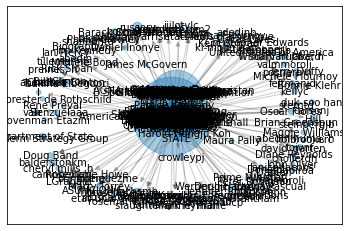

In [15]:
# 画出网络图
show_graph(graph)

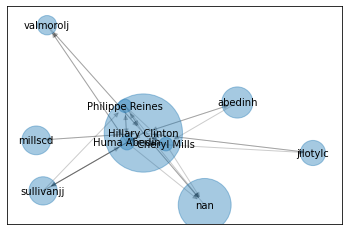

In [16]:
# 将完整的图谱进行精简
# 设置PR值的阀值，筛选大于阀值的重要核心节点
pagerank_threshold = 0.008
small_graph = graph.copy()

# 剪掉PR值小于pagerank_threshold的节点
for n, p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold:
        small_graph.remove_node(n)
# 画网络图
show_graph(small_graph)

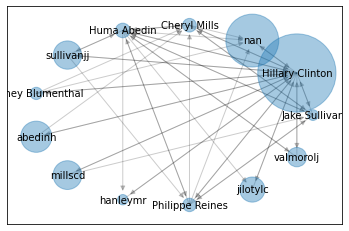

In [17]:
# 将完整的图谱进行精简
# 设置PR的值的阈值，筛选大于阈值的重要核心结点
pagerank_threshold = 0.005
# 复制一份计算好的网络图
small_graph = graph.copy()
# 剪掉PR值小于pagerank_threshold的结点
for n, p_rank in graph.nodes(data=True):
    if p_rank['pagerank'] < pagerank_threshold:
        small_graph.remove_node(n)
# 画出网络图，采用的是circular_layout布局让筛选出来的点组成一个圆
show_graph(small_graph, 'circular_layout')

对于代码中的几个模块做个简单的说明：

####  1、函数定义
人物的名称需要统一，因此设置了unify_name函数，同时设置了show_graph函数将网络图可视化。NetworkX提供了多种可视化布局，这里使用Spring_layout布局，也就是呈现出中心放射状。

除了Spring_layout外，NetworkX还有另外三种可视化布局，circular_layout(在一个圆环上均匀分布结点)，random_layout(随机分布节点)，shell_layout(结点都在同心圆上)

### 2、计算边权值
邮件的发送者和接收者的邮件往来可能不止一次，我们需要用两者之间邮件往来的次数计算这两者之间的边的权重，所以使用了edges_weights_temp数组存储权重。而上面介绍过的NetworkX中添加权重边（使用add_weighted_edges_from函数）的时候，接受的是u,v,w的三元数组，因此我们还需要对格式进行转换，具体转换方式见代码。

### 3、PR值计算以及筛选
使用的nx.pagerank(graph)计算了结点的PR值。由于结点的数量很多，我们设置了PR值阈值，即pagerank_threshold=0.005,然后遍历结点，删除小于PR值阈值的节点，形成新的图small_graph，最后对small_graph进行可视化（对应运行结果的第二张图）。

## 总结

1、使用PageRank算法，我们可以通过矩阵乘法求得网页的权重，同时也可以使用Python的NetworkX得到相同的结果。

2、根据上面的实践我们将一张复杂的网络图，通过PR值的计算、筛选，最终得到一张精简的网络图。其中使用了Python的NetworkX工具，包括创建图、结点、边以及PR值的计算。

3、实际上掌握了PageRank的理论之后，在实战的时候往往就是一行代码的事情。但是项目与理论不同，项目中涉及的理论数据量比较大，我们会花费80%的时间（或者80%的代码量）在预处理过程中，比如上面的项目中，我们对别名进行了统一，对边的权重进行了计算，同时还需要把计算好的结果以可视化的方式呈现。

4、PageRank实战
- 数据集
    - 希拉里邮件数据集，513个人名，9306封邮件，人名存在别名的情况
    - 目标：计算不同的人在邮件数据集中的权重，筛选重要的人物，绘制网络图
- networkx使用
    - 图创建
        - 无向图：nx.Graph()
        - 有向图：nx.DiGraph()
    - 结点操作
        - 增加：G.add_node()和G.add_nodes_from()
        - 删除：remove_node()和remove_nodes_from()
        - 查询：nodes()得到所有的结点，number_of_nodes()得到节点的个数
    - 边操作
        - 增加：add_edge(),add_edges_from(),add_weighted_edges_from()
        - 删除：remove_edge()和remove_adges_from()
        - 查询：edges()访问图中所有的边，number_of_edges()得到边的个数
- 项目流程
    - 准备阶段：数据探索、数据清洗、特征选择
    - 挖掘阶段：PR值计算、PR值筛选、可视化
    - 掌握使用NetworkX计算PR值以及网络图的可视化
    
![](PageRank实战.png)